# Language Bias Analysis

# Setup

In [1]:
import json
import math
import numpy as np
import os
import pandas as pd
import random
import requests
import shlex
import subprocess
import sys
import time
import uuid
from pathlib import Path
from PIL import ImageFont, ImageDraw, Image

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import display
import seaborn as sns

import multiprocessing as mp

# set seed
random.seed(42)
np.random.seed(42)

In [2]:

sns.set_context("paper")
sns.set_style("ticks")

## directory

In [3]:
import platform

BIN_MAPS = {"Darwin": "mac", "Linux": "linux"}

HOME_DIR = Path("./").expanduser() # change if putting notebook diff folder
HOME_DIR

sys.path.append(str(HOME_DIR / "src"))
bin_dir = HOME_DIR / Path("./bin")
bin_path = bin_dir / BIN_MAPS[platform.system()] / "candidate_crops"
model_path = bin_dir / "fastgaze.vxm"
data_dir = HOME_DIR / Path("./data/")
data_dir.exists()


SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

FONT_DIR = HOME_DIR / Path("./fonts/")


## functions from original code

In [7]:
## OTHER CODE

def img_resize_fixed_aspect(img, fixed_width=None, fixed_height=256):
    w, h = img.size
    if fixed_height:
        return img.resize((int(w * fixed_height / h), fixed_height))
    elif fixed_width:
        raise Exception("Not implemented.")


def attach_img(
    images,
    fixed_height=None,
    display_img_full_size=False,
    display_figsize=None,
    pixel_size_upperbound=None,
):
    """
    Given a list of images (of PIL Image class or image paths), attach them horizontally and return a new image.
    
    images: list of images or a list of paths to images
    fixed_height: all images are resized (while fixing the aspect ratio) to the specified height.
    If you don't want to resize, set this to None
    display_img_full_size: If true, will display the image at full resolution
    display_figsize: if given, as (x,y), will use matplotlib to display images with figsize=(x,y)
    pixel_size_upperbound: if given, images with width or height above this number will be resized down 
    while fixing the aspect ratio until both the width and height is at most the number.
    """
    if isinstance(images[0], str) or isinstance(images[0], Path):
        images = [Image.open(str(img_path)) for img_path in images]
    if fixed_height is not None:
        images = [
            img_resize_fixed_aspect(img, fixed_height=fixed_height) for img in images
        ]
    if pixel_size_upperbound is not None:
        for i in range(len(images)):
            w, h = images[i].size
            if w > pixel_size_upperbound:
                images[i] = images[i].resize(
                    (pixel_size_upperbound, int(pixel_size_upperbound / w * h))
                )
            w, h = images[i].size
            if h > pixel_size_upperbound:
                images[i] = images[i].resize(
                    (int(pixel_size_upperbound / h * w), pixel_size_upperbound)
                )
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new("RGB", (total_width, max_height))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.size[0]
    if display_img_full_size:
        display(new_im)  # This shows image at full resolution
    if display_figsize:
        fig = plt.figure(figsize=display_figsize)
        plt.imshow(
            np.asarray(new_im)
        )  # This shows scaled down version in matplotlib plot using figsize
    return (new_im, widths, heights)


GROUP_THRESHOLD = 5
def get_grouped_images_dict_wiki(
    wiki_pandas, by_columns=["race"], group_threshold=GROUP_THRESHOLD
):
    """
    race_threshold: if the size of the group is less than the threshold, then ignore the group to be in the dictionary
    """
    grouped_images_dict = {}
    grouped_images_race = wiki_pandas.groupby(by_columns)

    for name, group in grouped_images_race:
        print(name)
        print("Size of the group:", len(group))
        if group_threshold is not None:
            if len(group) < group_threshold:
                print("\tSize is smaller than", group_threshold, ". Skip this group.")
                continue
        grouped_images_dict[name] = group

    return grouped_images_dict


# In general, we can give the name of two groups in grouped_images_dict, and return this statistics of how many land in each
def compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    normalize=False,
    save_dir=SAVE_DIR_ATTACHED,
    num_iterations=200,
    fixed_height=None,
    pixel_size_upperbound=None,
    save_result=RESULT_FILE_PATH,
    log_every=100,
    print_summary=True,
    save_setting="default",
):
    """
    Given a list of group names, which are keys of the dictionary grouped_images_dict,
    whose values are pandas dataframe with column "path",
    return the number of times salient points lands in each of the group out of num_iterations iterations of sampling.
    
    Args:
        grouped_images_dict: a dictionary where keys are group names, and values are pandas dataframe which contains 'path'
    """
    start_time = time.time()
    stats = compute_group_comparison(
        [grouped_images_dict[group_name] for group_name in group_name_list],
        save_dir=save_dir,
        num_iterations=num_iterations,
        fixed_height=fixed_height,
        log_every=log_every,
        pixel_size_upperbound=pixel_size_upperbound,
    )
    if normalize:
        stats = stats / num_iterations
    if print_summary:
        print("The groups entered are: " + str(group_name_list))
        print("The statistic is: " + str(stats))
        print("Size of the sample: " + str(num_iterations))
    if save_result:
        with open(RESULT_FILE_PATH, "a") as fp:
            to_write_info_dict = {
                "group_name_list": group_name_list,
                "stats": stats,
                "num_iterations": num_iterations,
            }
            if save_setting:
                to_write_info_dict["setting"] = save_setting
            fp.write(str(to_write_info_dict) + "\n")
    time_used = time.time() - start_time
    print("total time used:", time_used, "seconds.")
    print("time used per comparison:", time_used / num_iterations, "seconds.")
    return stats


def compute_group_comparison(
    df_list,
    save_dir=SAVE_DIR_ATTACHED,
    num_iterations=200,
    log_every=100,
    warn_outside_ori_image=True,
    fixed_height=None,
    pixel_size_upperbound=None,
):
    """
    Given a list of dataframe of groups g_1, g_2, ..., g_k, each of which contains the column 'path' to the image file:
    - sample uniformly one image from each group
    - attach image into one image
    - apply saliency mapping
    - find the number of times max salient points land in each picture
    """
    num_max_salient_per_group = np.zeros(len(df_list))
    for i in range(num_iterations):
        salient_info = None
        while salient_info is None:  # if cmd in get_salient_info failed, resample
            # Sample images as paths
            sample_img_paths = [(df.sample())["path"].item() for df in df_list]
            attached_img, widths, heights = attach_img(
                sample_img_paths,
                fixed_height=fixed_height,
                pixel_size_upperbound=pixel_size_upperbound,
            )
            attached_path = str(save_dir) + "/" + str(i) + ".jpg"
            attached_img.save(attached_path)
            # try to get salient information. Will get None if fails.
            salient_info = get_salient_info(attached_path)

        # get salient point and where it lands
        all_salient_points = salient_info["salient_point"]
        if len(all_salient_points) > 1:
            print(
                "Warning: there is more than one maximum salient point. Using the first one returned from the algorithms."
            )
        salient_point_x, salient_point_y = all_salient_points[0]
        max_salient_pic_index = locate_which_img(salient_point_x, widths)
        if warn_outside_ori_image and salient_point_y >= heights[max_salient_pic_index]:
            # this means the point is outside of the original image
            print(
                "Warning: salient point is located at the background from attaching images, outside of original."
            )
        num_max_salient_per_group[max_salient_pic_index] += 1
        if (i + 1) % log_every == 0:
            print((i + 1), "/", num_iterations, "iterations of sampling has been done.")
    return num_max_salient_per_group


def get_salient_info(img_path):
    """
    Given a path (as an instance of Path or a string or an image), output the salient information.
    
    The output is a dictionary with:
    'salient_point': a list of pixels, usually only one. E.g. [[507, 328]]
    'crops': a list of crops (for each aspect ratio) in the format crop_x crop_y crop_w crop_h
    'all_salient_points': the pixel location at the original image with its salient score. It is a list of
    [x, y, salient score]
    """
    if isinstance(img_path, str):
        img_path = Path(img_path)
    try:
        cmd = f"{str(bin_path)} {str(model_path)} '{img_path.absolute()}' show_all_points"
        output = subprocess.check_output(cmd, shell=True)  # Success!
        return parse_output(output)
    except:
        print("Running the model to get salient point fails. Returning None.")
        return None


def parse_output(output):
    output = output.splitlines()
    final_output = {"salient_point": [], "crops": [], "all_salient_points": []}
    key = "salient_point"
    for i, line in enumerate(output):
        line = line.split()
        if len(line) in {2, 4}:
            line = [int(v) for v in line]
            if i != 0:
                key = "crops"
        elif len(line) == 3:
            key = "all_salient_points"
            line = [float(v) for v in line]
        else:
            raise RuntimeError(f"Invalid line: {line}")
        final_output[key].append(line)
    return final_output

def locate_which_img(location, widths):
    """
    Given a list of widths of the images that are attached (from left to right), and a location,
    output what image contains that location.
    E.g. widths = 100, 200, 100
    location = 50 --> index = 0
    location = 350 --> index = 2
    location = 100 --> index = 1
    location >= 400 --> index = -1
    """
    index = 0
    while location >= widths[index]:
        location -= widths[index]
        index += 1
        if index >= len(widths):
            return -1
    return index

def compute_saliency_stats(
    file_path_list,
    sample=None,
    percentile_queries=[25, 50, 75, 90, 95, 100],
    fixed_height=None,
    pixel_size_upperbound=None,
    save_dir=SAVE_DIR_ATTACHED,
    log_every=100,
    print_summary=True,
    delete_img=True,
):
    """
    Given a list of paths to images, compute saliency statistics of interests of all those images.
    
    Args:
        sample: None if we want to compute all. If a number is given, only do the specified number of samples (without replacement)

    Returns:
        pandas dataframe with file_path as an index, and the statistics as a column
    """
    start_time = time.time()

    if sample is not None:
        file_path_list = random.sample(file_path_list, sample)

    result_data = {
        str(percent) + "%_tile": [] for percent in percentile_queries
    }  # all columns
    result_data["path"] = []  # rows of the data
    result_data["mean"] = []

    for i, path in enumerate(file_path_list):
        attached_img, widths, heights = attach_img(
            [path],
            fixed_height=fixed_height,
            pixel_size_upperbound=pixel_size_upperbound,
        )
        attached_path = str(save_dir) + "/" + str(i) + ".jpg"
        attached_img.save(attached_path)
        # try to get salient information. Will get None if fails.
        salient_info = get_salient_info(attached_path)
        # After getting the info delete the file:
        if delete_img:
            Path(attached_path).unlink()

        salient_scores = [point[2] for point in salient_info["all_salient_points"]]

        # put data in
        result_data["path"].append(path)
        result_data["mean"].append(np.mean(salient_scores))
        for percent in percentile_queries:
            result_data[str(percent) + "%_tile"].append(
                np.percentile(salient_scores, percent)
            )

        if (i + 1) % log_every == 0:
            print((i + 1), "iterations of sampling has been done.")

    time_used = time.time() - start_time
    print("total time used:", time_used, "seconds.")
    print("time used per comparison:", time_used / len(file_path_list), "seconds.")

    return pd.DataFrame.from_dict(result_data).set_index("path")


def plot_pairwise_stats(
    stat_dict,
    figsize=None,
    setting_name="unknown",
    num_iteration="unknown",
    confidence_interval_err=2,
    middle_band_width=0.1,
    x_label_angle=10,
):
    """
  Given a dictionary of pairs of group and comparison statisitcs:
  ('group1', 'group2'): [num_group1_is_picked, num_group2_is_picked]
  Plot the bar graph on all pairs in this format on the probability p that group1 is picked.
  
  The std error is assumed to be sqrt(p(1-p)/n), a confidence interval for Bernoulli inference.
  The bar graph plot +- 2 std err, giving 95% confidence interval.
  
  Args:
      confidence_interval_err: the width of the confidence interval in the plotsetting_name: the setting of this experiment. Only used for the title of the plot and name of the saved figure
      num_iteration: the number of samples used (int or str). Only used for the title of the plot and name of the saved figure
      x_label_angle: angle to rotate the x label. May need to increase for lengthy labels.
      middle_band_width: add two horizontal lines above and below 0.5 symmetrically to the plot, so creating a band of given width.
                    If None, no line is added.
  """
    x_labels = [
        "{}-{}".format(*pair[0]) + "\nhigher than\n" + "{}-{}".format(*pair[1])
        for pair in stat_dict.keys()
    ]
    prob = [val[0] / (val[0] + val[1]) for val in stat_dict.values()]
    total = [(val[0] + val[1]) for val in stat_dict.values()]
    y_err = [
        confidence_interval_err * math.sqrt(p * (1 - p) / n)
        for p, n in zip(prob, total)
    ]
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x_labels, prob, yerr=y_err)

    if middle_band_width is not None:
        ax.axhline(0.5, color="r", label=f"Demographic Parity")
    plt.xlim(-0.5, len(x_labels) - 0.5)
    plt.xticks(rotation=x_label_angle, fontsize=16)
    ax.set_ylabel("Probability $\pm$ 2 * error", fontsize=20)
    plt.ylim(0.0, 1.0)
    plt.yticks(fontsize=16)
    ax.yaxis.grid(True)
    plt.legend(fontsize=16)
    plt.title(f"Probabilities with {num_iteration} samples", fontsize=20)
    plt.tight_layout()
    plt.savefig(setting_name + "_n=" + str(num_iteration) + ".jpg")

# Analysis

In [13]:
# Setting
NUM_ITERATION = 1000  # 5000
FIXED_HEIGHT = (256)  #
DIM_BOUND = None # for scaleling large images 
SETTING_NAME = "10lang_530strings_width_matched"  # for saving results and plots

In [5]:
# CHOOSE DATASET TO ANALYZE: Load dataframe
#df_translated = pd.read_csv(data_dir / "translated_530.csv")
df_translated = pd.read_csv(data_dir / 'translated_530_width_matched.csv')

# CHOOSE IMAGE DIR
IMAGE_DIR = HOME_DIR / data_dir / Path("./images/")

IMAGE_DIR = HOME_DIR / data_dir / Path("./images/")

In [14]:
grouped_images_dict = get_grouped_images_dict_wiki(df_translated, by_columns=["language", "script_name"])

('Arabic', 'Arabic')
Size of the group: 529
('Bengali', 'Bengali–Assamese')
Size of the group: 529
('Chinese', 'Chinese (simplified)')
Size of the group: 529
('English', 'Latin')
Size of the group: 529
('Hindi', 'Devanagari')
Size of the group: 529
('Korean', 'Hangul')
Size of the group: 529
('Russian', 'Cyrillic')
Size of the group: 529
('Spanish', 'Latin')
Size of the group: 529
('Swahili', 'Latin')
Size of the group: 529
('Tamil', 'Tamil (Brahmic)')
Size of the group: 529
('Telugu', 'Telugu')
Size of the group: 529
('Vietnamese', 'Latin')
Size of the group: 529


In [15]:
all_lang_to_compare = list(grouped_images_dict.keys())
all_pairs_replicate_ori = [
    (all_lang_to_compare[i], all_lang_to_compare[j])
    for i in range(len(all_lang_to_compare))
    for j in range(i + 1, len(all_lang_to_compare))
]
all_pairs_replicate_ori

[(('Arabic', 'Arabic'), ('Bengali', 'Bengali–Assamese')),
 (('Arabic', 'Arabic'), ('Chinese', 'Chinese (simplified)')),
 (('Arabic', 'Arabic'), ('English', 'Latin')),
 (('Arabic', 'Arabic'), ('Hindi', 'Devanagari')),
 (('Arabic', 'Arabic'), ('Korean', 'Hangul')),
 (('Arabic', 'Arabic'), ('Russian', 'Cyrillic')),
 (('Arabic', 'Arabic'), ('Spanish', 'Latin')),
 (('Arabic', 'Arabic'), ('Swahili', 'Latin')),
 (('Arabic', 'Arabic'), ('Tamil', 'Tamil (Brahmic)')),
 (('Arabic', 'Arabic'), ('Telugu', 'Telugu')),
 (('Arabic', 'Arabic'), ('Vietnamese', 'Latin')),
 (('Bengali', 'Bengali–Assamese'), ('Chinese', 'Chinese (simplified)')),
 (('Bengali', 'Bengali–Assamese'), ('English', 'Latin')),
 (('Bengali', 'Bengali–Assamese'), ('Hindi', 'Devanagari')),
 (('Bengali', 'Bengali–Assamese'), ('Korean', 'Hangul')),
 (('Bengali', 'Bengali–Assamese'), ('Russian', 'Cyrillic')),
 (('Bengali', 'Bengali–Assamese'), ('Spanish', 'Latin')),
 (('Bengali', 'Bengali–Assamese'), ('Swahili', 'Latin')),
 (('Bengali',

In [11]:
all_pairs_replicate_ori[:30]

[(('Arabic', 'Arabic'), ('Bengali', 'Bengali–Assamese')),
 (('Arabic', 'Arabic'), ('Chinese', 'Chinese (simplified)')),
 (('Arabic', 'Arabic'), ('English', 'Latin')),
 (('Arabic', 'Arabic'), ('Hindi', 'Devanagari')),
 (('Arabic', 'Arabic'), ('Korean', 'Hangul')),
 (('Arabic', 'Arabic'), ('Russian', 'Cyrillic')),
 (('Arabic', 'Arabic'), ('Spanish', 'Latin')),
 (('Arabic', 'Arabic'), ('Swahili', 'Latin')),
 (('Arabic', 'Arabic'), ('Tamil', 'Tamil (Brahmic)')),
 (('Arabic', 'Arabic'), ('Telugu', 'Telugu')),
 (('Arabic', 'Arabic'), ('Vietnamese', 'Latin')),
 (('Bengali', 'Bengali–Assamese'), ('Chinese', 'Chinese (simplified)')),
 (('Bengali', 'Bengali–Assamese'), ('English', 'Latin')),
 (('Bengali', 'Bengali–Assamese'), ('Hindi', 'Devanagari')),
 (('Bengali', 'Bengali–Assamese'), ('Korean', 'Hangul')),
 (('Bengali', 'Bengali–Assamese'), ('Russian', 'Cyrillic')),
 (('Bengali', 'Bengali–Assamese'), ('Spanish', 'Latin')),
 (('Bengali', 'Bengali–Assamese'), ('Swahili', 'Latin')),
 (('Bengali',

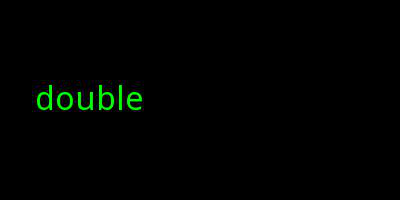

In [12]:
# Test image
Image.open('./data/images/English_1.jpeg')

#Image.open('./data/images_width_matched/English_1.jpeg')

In [46]:
#def name(x):
#    return x.replace('/content/gdrive/MyDrive/Colab Notebooks/twitter_algo_bias_challenge','.')
#df_translated["path"] = df_translated.path.apply(lambda x: name(x))

In [17]:

max_salient_compare_dict = {}

# function to allow multiprocessing, grouped_imaged_dict comes from cells above
def compute_comparison_from_group_name_multi(pair):

  max_salient_compare_dict[pair] = compute_comparison_from_group_name(
        grouped_images_dict,
        pair,
        num_iterations=NUM_ITERATION, # CHANGE
        save_setting=SETTING_NAME,
        fixed_height=FIXED_HEIGHT,
        pixel_size_upperbound=DIM_BOUND, 
    )
  return max_salient_compare_dict

with mp.Pool(5) as P: # mp.cpu_count()-
    result = P.map(compute_comparison_from_group_name_multi, all_pairs_replicate_ori)



Running the model to get salient point fails. Returning None.Running the model to get salient point fails. Returning None.

Running the model to get salient point fails. Returning None.
Running the model to get salient point fails. Returning None.
Running the model to get salient point fails. Returning None.
Running the model to get salient point fails. Returning None.
Running the model to get salient point fails. Returning None.
Running the model to get salient point fails. Returning None.
Running the model to get salient point fails. Returning None.
Running the model to get salient point fails. Returning None.
Running the model to get salient point fails. Returning None.Running the model to get salient point fails. Returning None.

100 / 1001000  / iterations of sampling has been done.
1000 iterations of sampling has been done.
100 / 1000100  iterations of sampling has been done.
/ 1000 iterations of sampling has been done.
100 / 1000 iterations of sampling has been done.
Running the

# Plots

In [124]:
# code borrowed
import ast
import pickle

all_dicts = []
with open(data_dir / "./results_7phrases.txt", "r") as f:
    lines = f.read().split("\n")
for i, l in enumerate(lines):
    if not l.strip():
        continue
    try:
        l = l.replace("array", "").replace("dict_keys", "").replace("\n", "")
        all_dicts.append(ast.literal_eval(l))
    except:
        print(
            f"Cannot read dictionary from line {i} (maybe empty line if nothing shows after this, e.g. last line):",
            l,
        )

df_results = pd.DataFrame(all_dicts)

In [125]:
# get specific group
dict_results = df_results[df_results.num_iterations == 10].set_index("group_name_list")[
    "stats"
].to_dict()

In [85]:
def plot_pairwise_stats(
    stat_dict,
    figsize=None,
    setting_name="unknown",
    num_iteration="unknown",
    confidence_interval_err=2,
    middle_band_width=0.1,
    x_label_angle=10,
    annotate=False,
):
    """
  Given a dictionary of pairs of group and comparison statisitcs:
  ('group1', 'group2'): [num_group1_is_picked, num_group2_is_picked]
  Plot the bar graph on all pairs in this format on the probability p that group1 is picked.
  
  The std error is assumed to be sqrt(p(1-p)/n), a confidence interval for Bernoulli inference.
  The bar graph plot +- 2 std err, giving 95% confidence interval.
  
  Args:
      confidence_interval_err: the width of the confidence interval in the plotsetting_name: the setting of this experiment. Only used for the title of the plot and name of the saved figure
      num_iteration: the number of samples used (int or str). Only used for the title of the plot and name of the saved figure
      x_label_angle: angle to rotate the x label. May need to increase for lengthy labels.
      middle_band_width: add two horizontal lines above and below 0.5 symmetrically to the plot, so creating a band of given width.
                    If None, no line is added.
  """
    x_labels = [
        "{}-{}".format(*pair[0]) + "\nhigher than\n" + "{}-{}".format(*pair[1])
        for pair in stat_dict.keys()
    ]
    prob = [val[0] / (val[0] + val[1]) for val in stat_dict.values()]
    total = [(val[0] + val[1]) for val in stat_dict.values()]
    y_err = [
        confidence_interval_err * math.sqrt(p * (1 - p) / n)
        for p, n in zip(prob, total)
    ]
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x_labels, np.array(prob) - 0.5, yerr=y_err, color="0.5")
    if annotate:
        for i, v in enumerate(prob):
            y = (max(prob) + 0.05) if v > 0.5 else (min(prob) - 0.1)
            y = y - 0.5
            ax.text(
                i,
                y,
                f"{100*((v-0.5)):.0f}%",
                color="red",
                fontweight="bold",
                fontsize=16,
                ha="center",
            )

    if middle_band_width is not None:
        ax.axhline(0, color="k", label=f"Demographic Parity")
    plt.xlim(-0.5, len(x_labels) - 0.5)
    plt.ylim(-0.5, 0.5)
    ax.set_ylabel("Probability - 0.5\n$\pm$ 2 * error", fontsize=20)
    sns.despine(offset=10)
    plt.xticks(rotation=x_label_angle, fontsize=16)
    plt.yticks(fontsize=16)
    ax.yaxis.grid(True)
    plt.legend(fontsize=16)
    plt.title(f"{num_iteration} samples", fontsize=20)
    plt.tight_layout()
    plt.savefig(setting_name + "_n=" + str(num_iteration) + ".jpg")

TODO:
+ filter functions for these dicts


In [100]:
# FILTER

names =[(('Arabic', 'Arabic'), ('Hindi', 'Devanagari'))]
df_results.query('group_name_list in @names')

,group_name_list,stats,num_iterations,setting
0,"((Arabic, Arabic), (Hindi, Devanagari))","[0.0, 2.0]",2,10lang_7phrases
21,"((Arabic, Arabic), (Hindi, Devanagari))","[0.0, 2.0]",2,10lang_7phrases
92,"((Arabic, Arabic), (Hindi, Devanagari))","[1.0, 9.0]",10,10lang_7phrases


In [103]:
def split_tuple(x):
    return x[0][0],x[1][1]

df_results.head().group_name_list.apply(lambda x: split_tuple(x))

0              (Arabic, Devanagari)
1        (Arabic, Bengali–Assamese)
2    (Arabic, Chinese (simplified))
3                   (Arabic, Latin)
4         (Arabic, Tamil (Brahmic))
Name: group_name_list, dtype: object

In [126]:
df_results["a"],df_results["b"] = df_results.group_name_list.str

df_results["language1"],df_results["script1"] = df_results.a.str
df_results["language2"],df_results["script2"] = df_results.b.str

<ipython-input-126-d3f5d9cf6442>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_results["a"],df_results["b"] = df_results.group_name_list.str
<ipython-input-126-d3f5d9cf6442>:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_results["language1"],df_results["script1"] = df_results.a.str
<ipython-input-126-d3f5d9cf6442>:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_results["language2"],df_results["script2"] = df_results.b.str


In [123]:
lang='English'

df_results.query("language1 == @lang or language2 == @lang")

,group_name_list,stats,num_iterations,setting,a,b,language1,script1,language2,script2
3,"((Arabic, Arabic), (English, Latin))","[0.0, 2.0]",2,10lang_7phrases,"(Arabic, Arabic)","(English, Latin)",Arabic,Arabic,English,Latin
5,"((Bengali, Bengali–Assamese), (English, Latin))","[0.0, 2.0]",2,10lang_7phrases,"(Bengali, Bengali–Assamese)","(English, Latin)",Bengali,Bengali–Assamese,English,Latin
7,"((Arabic, Arabic), (English, Latin))","[0.0, 2.0]",2,10lang_7phrases,"(Arabic, Arabic)","(English, Latin)",Arabic,Arabic,English,Latin
20,"((Chinese, Chinese (simplified)), (English, La...","[0.0, 2.0]",2,10lang_7phrases,"(Chinese, Chinese (simplified))","(English, Latin)",Chinese,Chinese (simplified),English,Latin
33,"((English, Latin), (Telugu, Telugu))","[0.0, 2.0]",2,10lang_7phrases,"(English, Latin)","(Telugu, Telugu)",English,Latin,Telugu,Telugu
36,"((English, Latin), (Swahili, Latin))","[0.0, 2.0]",2,10lang_7phrases,"(English, Latin)","(Swahili, Latin)",English,Latin,Swahili,Latin
38,"((English, Latin), (Russian, Cyrillic))","[0.0, 2.0]",2,10lang_7phrases,"(English, Latin)","(Russian, Cyrillic)",English,Latin,Russian,Cyrillic
40,"((English, Latin), (Hindi, Devanagari))","[0.0, 2.0]",2,10lang_7phrases,"(English, Latin)","(Hindi, Devanagari)",English,Latin,Hindi,Devanagari
44,"((English, Latin), (Spanish, Latin))","[0.0, 2.0]",2,10lang_7phrases,"(English, Latin)","(Spanish, Latin)",English,Latin,Spanish,Latin
50,"((English, Latin), (Vietnamese, Latin))","[1.0, 1.0]",2,10lang_7phrases,"(English, Latin)","(Vietnamese, Latin)",English,Latin,Vietnamese,Latin


In [127]:
lang='English'

df_results.query("language1 == @lang or language2 == @lang")

,group_name_list,stats,num_iterations,setting,a,b,language1,script1,language2,script2
2,"((Arabic, Arabic), (English, Latin))","[0.0, 10.0]",10,10lang_7phrases,"(Arabic, Arabic)","(English, Latin)",Arabic,Arabic,English,Latin
12,"((Bengali, Bengali–Assamese), (English, Latin))","[0.0, 10.0]",10,10lang_7phrases,"(Bengali, Bengali–Assamese)","(English, Latin)",Bengali,Bengali–Assamese,English,Latin
21,"((Chinese, Chinese (simplified)), (English, La...","[0.0, 10.0]",10,10lang_7phrases,"(Chinese, Chinese (simplified))","(English, Latin)",Chinese,Chinese (simplified),English,Latin
30,"((English, Latin), (Hindi, Devanagari))","[10.0, 0.0]",10,10lang_7phrases,"(English, Latin)","(Hindi, Devanagari)",English,Latin,Hindi,Devanagari
31,"((English, Latin), (Korean, Hangul))","[10.0, 0.0]",10,10lang_7phrases,"(English, Latin)","(Korean, Hangul)",English,Latin,Korean,Hangul
32,"((English, Latin), (Russian, Cyrillic))","[7.0, 3.0]",10,10lang_7phrases,"(English, Latin)","(Russian, Cyrillic)",English,Latin,Russian,Cyrillic
33,"((English, Latin), (Spanish, Latin))","[3.0, 7.0]",10,10lang_7phrases,"(English, Latin)","(Spanish, Latin)",English,Latin,Spanish,Latin
34,"((English, Latin), (Swahili, Latin))","[9.0, 1.0]",10,10lang_7phrases,"(English, Latin)","(Swahili, Latin)",English,Latin,Swahili,Latin
35,"((English, Latin), (Tamil, Tamil (Brahmic)))","[7.0, 3.0]",10,10lang_7phrases,"(English, Latin)","(Tamil, Tamil (Brahmic))",English,Latin,Tamil,Tamil (Brahmic)
36,"((English, Latin), (Telugu, Telugu))","[8.0, 2.0]",10,10lang_7phrases,"(English, Latin)","(Telugu, Telugu)",English,Latin,Telugu,Telugu


In [128]:
# filter the dict 


dict_filter = (df_results.query("language1 == @lang or language2 == @lang")
               .set_index("group_name_list")["stats"]
               .to_dict())

In [129]:
dict_filter

{(('Arabic', 'Arabic'), ('English', 'Latin')): [0.0, 10.0],
 (('Bengali', 'Bengali–Assamese'), ('English', 'Latin')): [0.0, 10.0],
 (('Chinese', 'Chinese (simplified)'), ('English', 'Latin')): [0.0, 10.0],
 (('English', 'Latin'), ('Hindi', 'Devanagari')): [10.0, 0.0],
 (('English', 'Latin'), ('Korean', 'Hangul')): [10.0, 0.0],
 (('English', 'Latin'), ('Russian', 'Cyrillic')): [7.0, 3.0],
 (('English', 'Latin'), ('Spanish', 'Latin')): [3.0, 7.0],
 (('English', 'Latin'), ('Swahili', 'Latin')): [9.0, 1.0],
 (('English', 'Latin'), ('Tamil', 'Tamil (Brahmic)')): [7.0, 3.0],
 (('English', 'Latin'), ('Telugu', 'Telugu')): [8.0, 2.0],
 (('English', 'Latin'), ('Vietnamese', 'Latin')): [6.0, 4.0]}

<ipython-input-85-0aebb435c1ef>:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


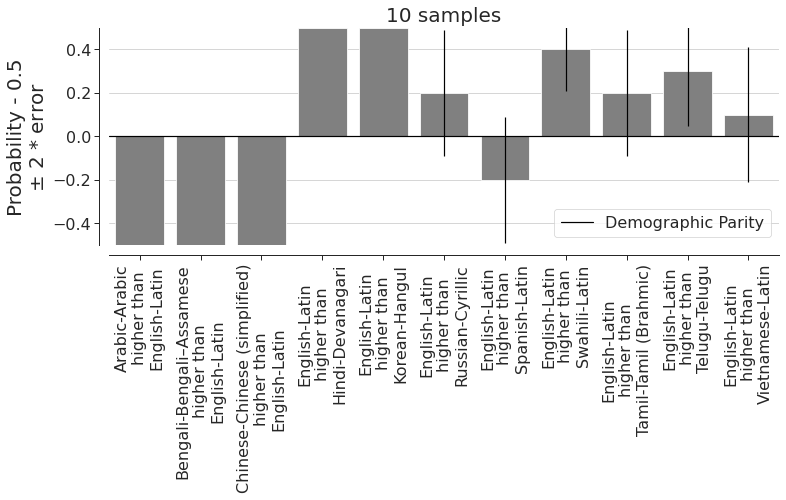

In [131]:

NUM_ITERATION = 10
SETTING_NAME = "10lang_7phrases"
plot_pairwise_stats(
    dict_filter,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(12, 4),
    x_label_angle=90,
)